# Illustrating the consequences of transformer fine-tuning for text classification

This notebook illustrates how fine-tuning a transformer encoder model for text classifciation affects its embedding behavior.

We take a pre-trained (multilingual) classifier developed by PolTextLab lead by Miklos Sebök: https://capbabel.poltextlab.com/ 

<br>
<a target="_blank" href="https://colab.research.google.com/github/haukelicht/advanced_text_analysis/blob/main/notebooks/encoder_finetuning/finetuning_logic_illustrated.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

**Note:** If running on Google Colab, make sure to use a GPU runtime (go to Runtime > Change runtime type, select "T4 GPU", and click save)

In [1]:
# check if on colab
COLAB = True
try:
    import google.colab
except:
    COLAB=False

if COLAB:
    # shallow clone of current state of main branch 
    !git clone --branch main --single-branch --depth 1 --filter=blob:none https://github.com/haukelicht/advanced_text_analysis.git
    
    # make repo root findable for python
    import sys, os
    sys.path.append(f"{os.getcwd()}/advanced_text_analysis/")
    
    !pip install -q umap-learn~=0.5.9.post2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, set_seed

import umap

import matplotlib.pyplot as plt

from typing import List

from tqdm.auto import tqdm

In [3]:
# check which device is available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [4]:
data_path = "data/labeled/fornaciari_we_2021"
data_path = ("/content/advanced_text_analysis/" if COLAB else "../../../") + data_path
data_path = Path(data_path)

In [5]:
SOURCE_MODEL_NAME = 'roberta-base'
# FINETUNED_MODEL_NAME = 'poltextlab/xlm-roberta-large-english-parlspeech-cap-v3'

#### Model access {style="color: orange"}

Note that to use the **fintuned model**, you first need to 

1. sign in to your hugging face acount
2. go to https://huggingface.co/poltextlab/xlm-roberta-large-english-parlspeech-cap-v3
3. complete the model access form
4. wait until you are granted access

If on colab, you also need to add a hugging face token (see https://huggingface.co/settings/tokens)  with "read" permissions to the environment variables in Colab: In the sidebar, click on the key symbol (⚿ ) and add an entry with the name `HF_TOKEN` and the value being your hugging face token.

## Load the data

#### Load the data

In [6]:
fp = data_path / "fornaciari_we_2021-pledge_binary.tsv"
if not fp.exists():
    url = "https://cta-text-datasets.s3.eu-central-1.amazonaws.com/labeled/fornaciari_we_2021/fornaciari_we_2021-pledge_binary.tsv"
    df = pd.read_csv(url, encoding = "ISO-8859-1")
    fp.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(fp, index=False, encoding = "ISO-8859-1")

df = pd.read_csv(fp, sep="\t")

df = df.loc[df['metadata__split']=='dev', ['text', 'label']]
df = df[~df.text.isna()]

In [7]:
id2label = {0: "no-pledge", 1: "pledge"}
label2id = {v: k for k, v in id2label.items()}

In [19]:
# draw 100 examples per class (sampled at random)
examples = df.groupby('label').sample(100, random_state=42).sample(frac=1.0, random_state=42)
# show 2 examples per class
examples.groupby('label').sample(2, random_state=42).to_dict(orient='records')

[{'text': 'BJP will take immediate and decisive action to address these issues on a priority basis .',
  'label': 0},
 {'text': 'A time to reestablish the core values that have made India unique .',
  'label': 0},
 {'text': 'National scholarships for boys and girls belonging to scheduled castes and scheduled tribes will be further increased .',
  'label': 1},
 {'text': 'Set up an independent National Fiscal Responsibility Council that will submit an annual report to the Parliament on the progress made in achieving our fiscal commitments .',
  'label': 1}]

## Inspect the transformer embeddings

Let's first define a function for getting the final contextualized embeddings ("last hidden state") computed by the model:

In [16]:
# helper function to get the transformer embeddings of a list of texts
def get_last_hidden_state(texts: List[str], tokenizer, model, batch_size: int=32): 
    set_seed(42)
    embeddings = []    
    for i in tqdm(range(0, len(texts), batch_size)):
        # tokenize texts
        batch_inputs = tokenizer(texts[i:i+batch_size], padding='max_length', truncation=True, return_tensors="pt")          
        # get the final hidden layer embeddings
        with torch.no_grad():
            batch_outputs = model(**batch_inputs.to(model.device), output_hidden_states=True)
            # selects all rows (:) and the first column (0) of the last_hidden_state tensor, which corresponds to the representation of the [CLS] that is typically used for classification tasks.
            batch_embeddings = batch_outputs.hidden_states[-1][:, 0].cpu().numpy()
        embeddings.append(batch_embeddings)
            
    embeddings = np.concatenate(embeddings, axis=0)  
    return embeddings

### before fine-tuning

Let's analyze the sentences' contextualized embeddings before fine-tuning the model for the classification task:

In [10]:
# load the source model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(SOURCE_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(SOURCE_MODEL_NAME, num_labels=len(label2id), label2id=label2id).to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# get the transformer embeddings
embeddings = get_last_hidden_state(examples.text.tolist(), tokenizer, model)

  0%|          | 0/7 [00:00<?, ?it/s]

Let's visualize how these examples of the different topics cluster in the original model's output embedding space.
To allow visual inspection, we'll reduce the embedding dimension to 2 dimensions using UMAP:

In [21]:
# Apply UMAP to reduce embeddings to 2D
reducer = umap.UMAP(n_components=2, random_state=42, n_jobs=1)
embeddings_2d = reducer.fit_transform(embeddings)

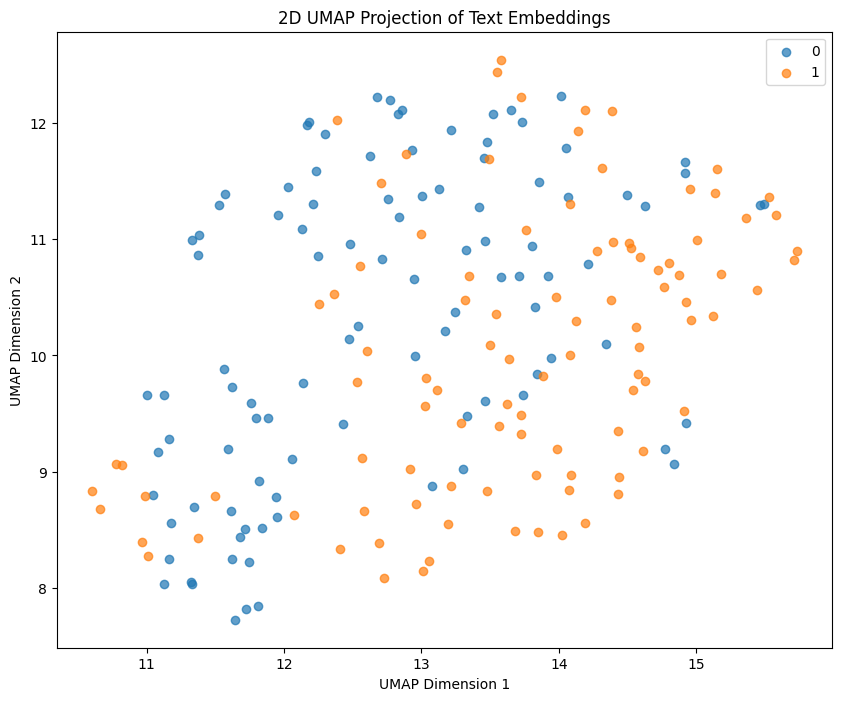

In [22]:
# Plot texts' embeddings in 2D coloring points by values in column label
plt.figure(figsize=(10, 8))
for label in examples['label'].unique():
    indices = examples['label'] == label
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label, alpha=0.7)
plt.legend()
plt.title('2D UMAP Projection of Text Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

There is no clear separating between examples of the different label classes.

### The effect of this disorder on classifications

Let's see how a classifier using these embeddings would classify a single sentence:

In [23]:
text = examples.text.values[0]
true_label = examples.label.values[0]
print("Text:", repr(text))
print("True Label:", repr(true_label))

Text: 'National security is dependent on a sound defence policy, a sound foreign policy and wise leadership .'
True Label: 0


Inputting the tokenized version fo the text to the model with the **classification head** outputs logits:


In [24]:
# get the logits for the first text
text = examples.text.values[0]
inputs = tokenizer(text, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs.to(model.device))
logits = outputs.logits.cpu().detach().numpy()[0]

There are many values as label classes in `logits`:

In [25]:
logits.shape

(2,)

Because interpreting logits is hard, let's the logits toprobabilities using the softmax function:

In [26]:
import torch.nn.functional as F

# Apply softmax to logits and sort by probability
probs = F.softmax(torch.tensor(logits), dim=0).numpy()
# map probs to label class names
probs_dict = dict(zip(label2id.keys(), probs))
# sort by probability
probs_dict = dict(sorted(probs_dict.items(), key=lambda item: item[1]))

In [27]:
# Apply softmax to logits
probs = F.softmax(torch.tensor(logits), dim=0).numpy()
# sort the softmax logits and corresponding labels
sorted_indices = np.argsort(probs)
probs = probs[sorted_indices]

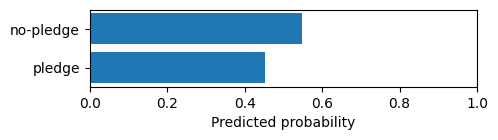

In [37]:
# Plot the softmax logits as a bar plot
plt.figure(figsize=(5, 1))
plt.barh(list(probs_dict.keys()), list(probs_dict.values()))
plt.xlabel('Predicted probability')
plt.xlim(0, 1)
plt.ylabel('')
# plt.title('Softmax of Logits for Topics')
plt.show()

We can see that the most likely label class is _wrong_ according to the 'true' label.

But what is more striking is that the classifier seems **really undecided** about what topic it should predict for the sentence!

Well, this is understandable. As we have seen above, the model cannot really separate between texts from different label categories.

This is because it has _not_ been finetuned for this classification task.

So let's look how this looks for a classifier that _has_ been finetuned for this task ☺️

## after fine-tuning

Now, let's see what happens if we do the same for the **model that has been _finetuned_** on task-specific labeled data:

In [33]:
# load the source model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(FINETUNED_MODEL_NAME).to(device)

config.json:   0%|          | 0.00/2.11k [00:00<?, ?B/s]

#### nice clustering of output embeddings by label class after finetuning ✅ 

Below you set, in contrast to the source model, the finetuned model produces contextualized embeddings that are nicely clustering by label class of the inputted texts:

In [34]:
# get the transformer embeddings
finetuned_embeddings = get_last_hidden_state(examples.text.tolist(), tokenizer, model)

  0%|          | 0/20 [00:00<?, ?it/s]

In [35]:
# Apply UMAP to reduce embeddings to 2D
reducer = umap.UMAP(n_components=2, random_state=42, n_jobs=1)
finetuned_embeddings_2d = reducer.fit_transform(finetuned_embeddings)

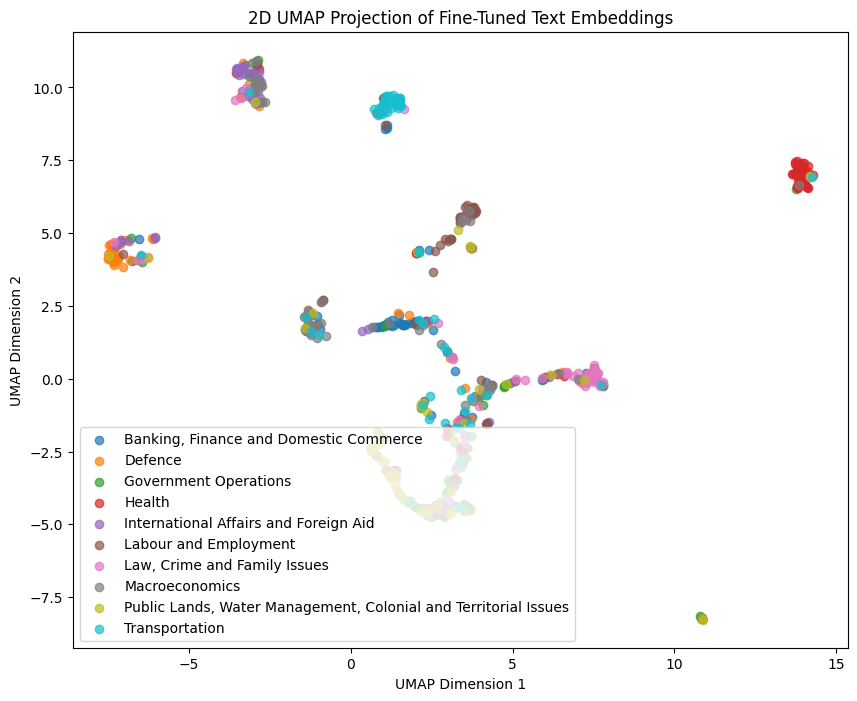

In [36]:
# Plot texts' embeddings in 2D coloring points by values in column label
plt.figure(figsize=(10, 8))
for label in examples['label'].unique():
    indices = examples['label'] == label
    plt.scatter(finetuned_embeddings_2d[indices, 0], finetuned_embeddings_2d[indices, 1], label=label, alpha=0.7)
plt.legend()
plt.title('2D UMAP Projection of Fine-Tuned Text Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

#### High-certainty predicted label class probabilties ✅

Let's look at the logits predicted by this model

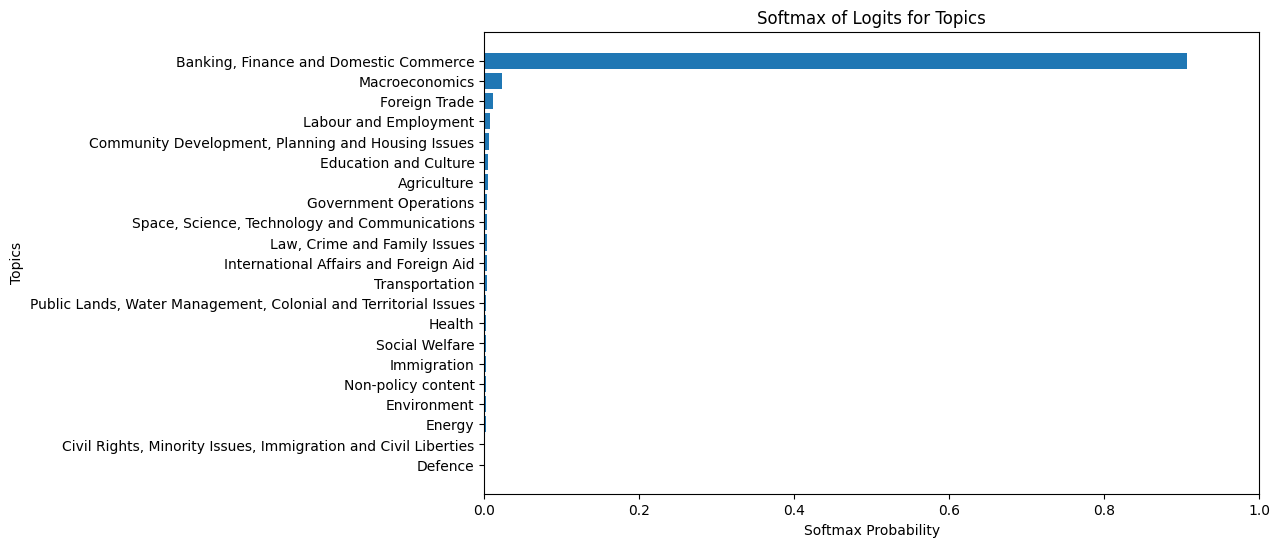

In [37]:
# get the logits for the first text
# NOTE: we are reusing `text` defined above (`text = examples.text.values[0]`)

inputs = tokenizer(text, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs.to(model.device))
logits = outputs.logits.cpu().detach().numpy()[0]

# Apply softmax to logits and sort by probability
probs_finetuned = F.softmax(torch.tensor(logits), dim=0).numpy()
probs_finetuned_dict = dict(zip(label2id.keys(), probs_finetuned))
probs_finetuned_dict = dict(sorted(probs_finetuned_dict.items(), key=lambda item: item[1]))

# Plot the softmax logits as a bar plot
plt.figure(figsize=(10, 6))
plt.barh(list(probs_finetuned_dict.keys()), list(probs_finetuned_dict.values()))
plt.xlabel('Softmax Probability')
plt.xlim(0, 1)
plt.ylabel('Topics')
plt.title('Softmax of Logits for Topics')
plt.show()

Now this looks much better! The most likely label class aligns with the "true" label with very high probability

In [38]:
true_label

'Banking, Finance and Domestic Commerce'

## Additional insights

#### The fine-tuned model gives better cluster assignments

From the session on sentence embedding clustering and topic modeling, you know that -- given "true" labels -- we can assess the clustering performance of a model using the silhoutte and coherence scores.

These metrics show that the finetuned model's clustering aligns much more with the categorization of the "true" label indicator than the source model:

In [39]:
from sklearn.metrics import silhouette_score

# Compute Silhouette Score for embeddings
labels = examples['label'].astype('category').cat.codes
silhouette_score_embeddings = silhouette_score(embeddings, labels)
print(f'Silhouette Score for embeddings: {silhouette_score_embeddings}')

# Compute Silhouette Score for finetuned_embeddings
silhouette_score_finetuned_embeddings = silhouette_score(finetuned_embeddings, labels)
print(f'Silhouette Score for finetuned embeddings: {silhouette_score_finetuned_embeddings}')

Silhouette Score for embeddings: -0.09063930809497833
Silhouette Score for finetuned embeddings: 0.04102429002523422


In [40]:
from sklearn.metrics import pairwise_distances

def compute_coherence(embeddings, labels):
    label_categories = labels.unique()
    coherence_scores = {}
    
    for label in label_categories:
        label_indices = labels == label
        label_embeddings = embeddings[label_indices]
        
        # Compute pairwise distances within the label category
        distances = pairwise_distances(label_embeddings)
        
        # Compute coherence as the mean of the pairwise distances
        coherence = np.mean(distances)
        coherence_scores[label] = coherence
    
    return coherence_scores

# Compute coherence for embeddings
coherence_embeddings = compute_coherence(embeddings, examples['label'])
coherence_finetuned_embeddings = compute_coherence(finetuned_embeddings, examples['label'])

pd.DataFrame(coherence_embeddings.values(), index=coherence_embeddings.keys(), columns=['embeddings']).join(
    pd.DataFrame(coherence_finetuned_embeddings.values(), index=coherence_finetuned_embeddings.keys(), columns=['finetuned_embeddings'])
)

,embeddings,finetuned_embeddings
"Banking, Finance and Domestic Commerce",2.599046,30.442883
Defence,2.561888,25.815054
Government Operations,2.463580,28.387812
Health,2.600799,24.316713
International Affairs and Foreign Aid,2.494959,26.166527
Labour and Employment,2.979536,30.202049
"Law, Crime and Family Issues",2.767193,27.489395
Macroeconomics,2.840460,31.366772
"Public Lands, Water Management, Colonial and Territorial Issues",2.908067,28.136635
Transportation,2.919642,28.241816


#### How much do the embeddings change from the pre-trained checkpoint?

Finetuning changes the contextualized embeddings of text inputs to make them useful features for separating examples from different label classes.

But how extensive is this change? And how does this vary across examples?

Below we use the cosine similarity of sentences' embeddings pre vs. post finetuning to assess this question:

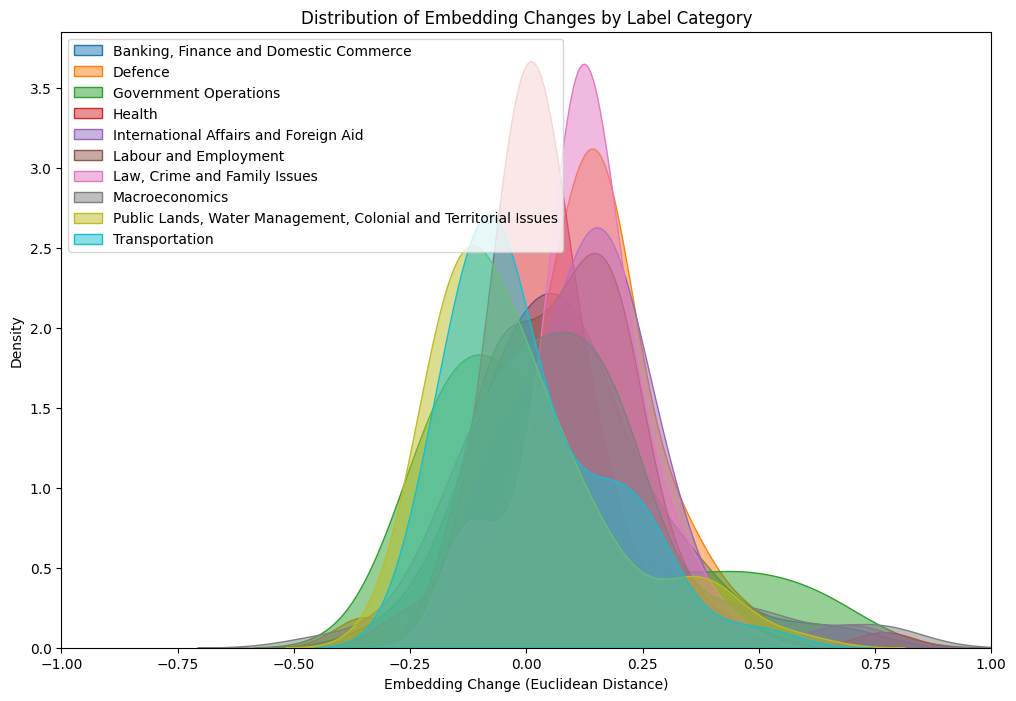

In [41]:
# import cosine_similarity from sklearn
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns

# Compute the change in embeddings as cosine similarity
embedding_changes = [cosine_similarity(embeddings[i].reshape(1, -1), finetuned_embeddings[i].reshape(1, -1))[0][0] for i in range(len(examples))]

# Add the changes to the examples dataframe
examples['embedding_change'] = embedding_changes

# Plot the distribution of embedding changes in a density plot by label category
plt.figure(figsize=(12, 8))
for label in examples['label'].unique():
    subset = examples[examples['label'] == label]
    sns.kdeplot(subset['embedding_change'], label=label, fill=True, alpha=0.5)

# set the x-axis limits to -1 and 1
plt.xlim(-1, 1)
plt.legend()
plt.title('Distribution of Embedding Changes by Label Category')
plt.xlabel('Embedding Change (Euclidean Distance)')
plt.ylabel('Density')
plt.show()

While the bulk of sentences' contextualized embeddings change relatively little through finetuning, there are quite some few instances where the change is very intense.

We look at these extreme examples below:

In [42]:
examples['embedding_change_abs'] = examples.embedding_change.abs()
examples.groupby('label').apply(lambda x: x.sort_values('embedding_change_abs', ascending=False).head(5)).reset_index(drop=True)

/var/folders/_c/cm0nk6y92rz2l6ct3npgw9tr0000gn/T/ipykernel_28427/3447005706.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  examples.groupby('label').apply(lambda x: x.sort_values('embedding_change_abs', ascending=False).head(5)).reset_index(drop=True)


,text,label,embedding_change,embedding_change_abs
0,Gone!,"Banking, Finance and Domestic Commerce",0.712771,0.712771
1,The overwhelming impression is that far too ma...,"Banking, Finance and Domestic Commerce",0.606925,0.606925
2,I could not agree more with you about the impo...,"Banking, Finance and Domestic Commerce",0.512053,0.512053
3,They operate in ways that undermine that profe...,"Banking, Finance and Domestic Commerce",0.414764,0.414764
4,We have heard about a number of issues relatin...,"Banking, Finance and Domestic Commerce",0.374507,0.374507
5,Our armed forces are being cut.,Defence,0.495186,0.495186
6,"Indeed, it is not just on the high seas that t...",Defence,0.462131,0.462131
7,Friend the Minister for Europe has done in ope...,Defence,0.377306,0.377306
8,"Otherwise, I fear that we will have to come ba...",Defence,0.356390,0.356390
9,"Otherwise, I fear that we will have to come ba...",Defence,0.356390,0.356390


Look at these examples:

- "Gone!" (labeled 'Banking, Finance and Domestic Commerce')
- "Order." (labeled 'Health')
- "Old habits die hard." (labeled 'International Affairs and Foreign Aid')
- "The answer is no." (labeled 'Law, Crime and Family Issues')
- "I am not going to give way." (labeled 'Macroeconomics')
- "Now, we are denying them that." (labeled 'Transportation')

Why are these instances assigned their corresponding labels?
This seems very suspicious!

This prompts us to theorize that the extent of (absolute) change in the contextualized embedding of a sentence might indicate that it has been mislabeled.
Why?
Well, the majority of, for example, texts in the 'Health' category likely fits this topical cluster well.
But to move "Order." to this health cluster, the embedding has to be shifted a lot because it is just not a very health-related term.

In [45]:
examples.groupby('label').apply(lambda x: x.sort_values('embedding_change_abs', ascending=True).head(5)).reset_index(drop=True)

/var/folders/_c/cm0nk6y92rz2l6ct3npgw9tr0000gn/T/ipykernel_28427/2928638058.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  examples.groupby('label').apply(lambda x: x.sort_values('embedding_change_abs', ascending=True).head(5)).reset_index(drop=True)


,text,label,embedding_change,embedding_change_abs
0,"For example, in 2006 RBS approached London and...","Banking, Finance and Domestic Commerce",0.013486,0.013486
1,The farmers have suffered a great deal since t...,"Banking, Finance and Domestic Commerce",-0.017321,0.017321
2,The tiresome obsession with grudge is wearing ...,"Banking, Finance and Domestic Commerce",0.019113,0.019113
3,That is unprecedented in our financial system ...,"Banking, Finance and Domestic Commerce",-0.019911,0.019911
4,Member for Bridgwater (Mr. Liddell-Grainger) a...,"Banking, Finance and Domestic Commerce",0.020234,0.020234
5,Friend the Member for New Forest East (Dr Lewi...,Defence,-0.006242,0.006242
6,"In the remaining time available to me, however...",Defence,0.010182,0.010182
7,"Clearly, the withdrawal of one of the potentia...",Defence,0.010834,0.010834
8,The hon.,Defence,0.012226,0.012226
9,"I beg to move, That this House: Deplores the u...",Defence,0.016125,0.016125
